In [2]:
from typing import Tuple
import itertools
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from monai.networks import nets, one_hot
from monai.metrics import compute_hausdorff_distance

import plotly.express as px
from plotly.colors import n_colors
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "simple_white"

import skimage as skm
from scipy import interpolate

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms

import torchio as tio

from kedro.extras.datasets.pandas import CSVDataSet
from kedro.extras.datasets.pickle import PickleDataSet

In [3]:
import os, sys
sys.path.append(os.path.abspath('../src'))

from tagseg.data import ScdEvaluator, MnmEvaluator
from tagseg.data.dmd_dataset import DmdH5DataSet, DmdH5Evaluator
from tagseg.models.trainer import Trainer
from tagseg.models.segmenter import Net
from tagseg.metrics.dice import DiceMetric
from tagseg.pipelines.model_evaluation.nodes import tag_subjects
from tagseg.data.dmd_dataset import DmdDataSet

In [4]:
model = 'model_cine_v6_tag_v1_dmd_v2'

df = PickleDataSet(filepath=f'../data/07_model_output/{model}/dmd_results.pt').load()
df = pd.DataFrame(list(df))

In [6]:
fig = px.scatter(df, x='timeframe', y='dice', color='patient_id')
fig.update_xaxes(title_text='Timeframe')
fig.update_yaxes(title_text='DSC', range=[0.65, .95])
fig.update_layout(height=800 / 1.62, width=800)
fig.show()

/opt/conda/envs/tagseg/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [21]:
fig.write_image("../../figures/patient-008-timeframe-dice.pdf")

In [9]:
timeframes = [1, 7, 14, 24]
datas = [
    list(map(lambda i: df[(df.patient_id == '008') & (df.timeframe == i)][['image', 'raw_mask', 'pred', 'dice']], timeframes)),
    list(map(lambda i: df[(df.patient_id == '204') & (df.timeframe == i)][['image', 'raw_mask', 'pred', 'dice']], timeframes)),
    list(map(lambda i: df[(df.patient_id == '207') & (df.timeframe == i)][['image', 'raw_mask', 'pred', 'dice']], timeframes))
]

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning:

NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning:

ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.



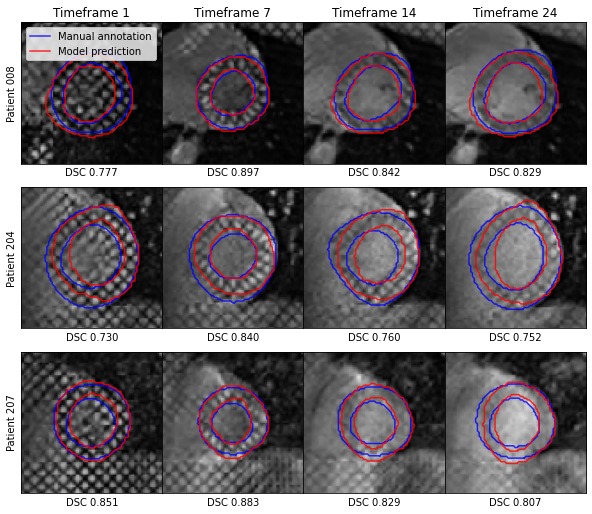

In [33]:
fig, ax = plt.subplots(3, 4, figsize=(8, 7))
pids = ['008', '204', '207']

for row, data in enumerate(datas):
    for i, tf in enumerate(timeframes):
        subject = data[i].iloc[0]
        raw_shape = subject.raw_mask.shape[2:]
        
        postprocess = transforms.Resize(raw_shape, interpolation=transforms.InterpolationMode.NEAREST)
        ax[row, i].imshow(postprocess(subject.image.data)[0, 0], cmap='gray')

        # ground truth
        contours = skm.measure.find_contours(subject.raw_mask.data[0, 0].numpy())
        for j, contour in enumerate(contours):
            ax[row, i].plot(*contour[:, ::-1].T, c='b', alpha=0.8, label='Manual annotation' if j == 0 else None)

        cy, cx = np.vstack(contours).mean(axis=0)

        # predictions
        contours = skm.measure.find_contours(subject.pred.data[0, 0].numpy())
        for j, contour in enumerate(contours):
            ax[row, i].plot(*contour[:, ::-1].T, c='r', alpha=0.8, label='Model prediction' if j == 0 else None)

        if row == 0:
            ax[row, i].set_title(f'Timeframe {tf}')
        if i == 0:
            ax[row, i].set_ylabel(f'Patient {pids[row]}')
        ax[row, i].set_xlabel(f'DSC {subject.dice:.3f}')
        ax[row, i].set_xticks([])
        ax[row, i].set_yticks([])

        padding = 40

        ax[row, i].set_xlim(cx - padding, cx + padding)
        ax[row, i].set_ylim(cy + padding, cy - padding)

ax[0, 0].legend(loc='upper left')

plt.tight_layout()
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, hspace=0., wspace=0.)
plt.savefig('../../figures/patient-008-example-segs.pdf', bbox_inches='tight')
plt.show()